In [386]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## Data Collection

In [387]:
# Path ke file CSV
path1 = "logs_CPI1H3-IF-47-01PJJ_KALKULUSLANJUT_DNS_2324_2.csv"
path2 = "logs_CPI1F4-IF-47-GAB.1PJJ_ALPRO_DRI_2324_2.csv"

datapath = path1 
df = pd.read_csv(datapath, delimiter=';', on_bad_lines='skip')

print(df.shape)
df.head()

(94555, 1)


,"Time,""User full name"",""Affected user"",""Event context"",Component,""Event name"",Description,Origin,""IP address"""
0,"19/09/24, 13:11,""DENI SAEPUDIN"",-,""Course: KAL..."
1,"19/09/24, 13:10,""DENI SAEPUDIN"",-,""Forum: Foru..."
2,"19/09/24, 13:09,""DENI SAEPUDIN"",-,""Forum: Foru..."
3,"19/09/24, 13:09,""DENI SAEPUDIN"",-,""Forum: Foru..."
4,"19/09/24, 13:09,""DENI SAEPUDIN"",-,""Course: KAL..."


## Data Pre-processing

Fixing Dataset

In [388]:
# Langkah 1: Baca raw file
with open(datapath, 'r', encoding='utf-8') as f:
    raw_data = f.read()

# Langkah 2: Bersihkan tanda kutip ganda dan karakter akhir seperti ;"
cleaned_data = raw_data.replace('""', '"').replace('\ufeff', '')
lines = cleaned_data.strip().splitlines()

# Langkah 3: Bersihkan tiap baris
cleaned_lines = []
for line in lines:
    if line.endswith('";'):
        line = line[:-2]  # Hapus ;" di akhir
    if line.startswith('"') and line.endswith('"'):
        line = line[1:-1]  # Hapus tanda kutip luar
    cleaned_lines.append(line)

# Langkah 4: Parsing manual untuk pisahkan kolom Date dan Time
processed_rows = []

for line in cleaned_lines:
    if not line.strip():
        continue
    if line.startswith('"') and line.endswith('"'):
        line = line[1:-1]

    try:
        # Pisahkan date dan time
        date_part, rest = line.split(',', maxsplit=1)
        time_part, rest = rest.split(',', maxsplit=1)

        # Gunakan csv.reader untuk parsing kolom selanjutnya
        parsed_rest = next(csv.reader([rest], delimiter=',', quotechar='"'))
        parsed_row = [date_part.strip('"'), time_part.strip()] + parsed_rest
        processed_rows.append(parsed_row)
    except Exception as e:
        print("Baris gagal diproses:", line)
        print("Error:", e)

# Langkah 5: Definisikan nama kolom
columns = ['Date', 'Time', 'User full name', 'Affected user', 'Event context',
           'Component', 'Event name', 'Description', 'Origin', 'IP address']

# Langkah 6: Buat DataFrame
df = pd.DataFrame(processed_rows[1:], columns=columns)  # [1:] karena baris pertama adalah header duplikat

# Atur agar index dimulai dari 1
df.index = df.index + 1

# Tampilkan hasil
print("Daftar Kolom:\n", df.columns.tolist())

def show_table(df, max_rows=20, max_cols=10, max_height=400):
    html = df.to_html(
        max_rows=max_rows,
        max_cols=max_cols,
        border=0,
        justify='center',
        escape=False
    ).replace(
        '<table',
        f'<div style="overflow:auto; max-height:{max_height}px;"><table style="width:auto; border-collapse: collapse;"'
    ).replace(
        '</table>',
        '</table></div>'
    )
    display(HTML(html))

display(HTML(f"<b>{datapath}</b> - Jumlah Baris: {df.shape[0]}, Jumlah Kolom: {df.shape[1]}"))
show_table(df)

Daftar Kolom:
 ['Date', 'Time', 'User full name', 'Affected user', 'Event context', 'Component', 'Event name', 'Description', 'Origin', 'IP address']


,Date,Time,User full name,Affected user,Event context,Component,Event name,Description,Origin,IP address
1,19/09/24,13:11,DENI SAEPUDIN,-,Course: KALKULUS LANJUT IF-47-01PJJ [DNS],System,Course viewed,The user with id '23956' viewed the course with id '45721'.,web,114.122.83.207
2,19/09/24,13:10,DENI SAEPUDIN,-,Forum: Forum Minggu 1,Forum,Discussion viewed,The user with id '23956' has viewed the discussion with id '1208980' in the forum with course module id '4097903'.,web,114.122.83.207
3,19/09/24,13:09,DENI SAEPUDIN,-,Forum: Forum Minggu 1,Forum,Discussion viewed,The user with id '23956' has viewed the discussion with id '1208973' in the forum with course module id '4097903'.,web,114.122.83.207
4,19/09/24,13:09,DENI SAEPUDIN,-,Forum: Forum Minggu 1,Forum,Course module viewed,The user with id '23956' viewed the 'forum' activity with course module id '4097903'.,web,114.122.83.207
5,19/09/24,13:09,DENI SAEPUDIN,-,Course: KALKULUS LANJUT IF-47-01PJJ [DNS],System,Course viewed,The user with id '23956' viewed the course with id '45721'.,web,114.122.83.207
6,3/09/24,12:56,DENI SAEPUDIN,-,Course: KALKULUS LANJUT IF-47-01PJJ [DNS],System,Course viewed,The user with id '23956' viewed the course with id '45721'.,web,103.233.100.227
7,31/08/24,09:26,MUHAMMAD HAZMI,-,Course: KALKULUS LANJUT IF-47-01PJJ [DNS],System,Course viewed,The user with id '76439' viewed the course with id '45721'.,web,110.138.94.206
8,30/08/24,12:21,WILLY SUYANTO,WILLY SUYANTO,Course: KALKULUS LANJUT IF-47-01PJJ [DNS],System,Course user report viewed,The user with id '76261' viewed the user report for the course with id '45721' for user with id '76261'.,web,182.3.38.100
9,20/08/24,13:37,ERLANGGA JUNI SAPUTRA,-,File: Integral lipat tiga,File,Course module viewed,The user with id '75803' viewed the 'resource' activity with course module id '4098205'.,web,111.95.40.103
10,20/08/24,13:36,ERLANGGA JUNI SAPUTRA,-,File: Integral lipat dua #2,File,Course module viewed,The user with id '75803' viewed the 'resource' activity with course module id '4098181'.,web,111.95.40.103


Merge Date & Time

In [389]:
# Gabungkan kolom Date dan Time menjadi Timestamp
df['Timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%y %H:%M', errors='coerce')
df = df[['Timestamp'] + [col for col in df.columns if col != 'Timestamp']]

# Hapus kolom Date dan Time serta kolom yang tidak diperlukan
df.drop(columns=['Date', 'Time', 'Affected user', 'Origin', 'IP address'], inplace=True)

display(HTML(f"<b>{datapath}</b> - Jumlah Baris: {df.shape[0]}, Jumlah Kolom: {df.shape[1]}"))
show_table(df)

,Timestamp,User full name,Event context,Component,Event name,Description
1,2024-09-19 13:11:00,DENI SAEPUDIN,Course: KALKULUS LANJUT IF-47-01PJJ [DNS],System,Course viewed,The user with id '23956' viewed the course with id '45721'.
2,2024-09-19 13:10:00,DENI SAEPUDIN,Forum: Forum Minggu 1,Forum,Discussion viewed,The user with id '23956' has viewed the discussion with id '1208980' in the forum with course module id '4097903'.
3,2024-09-19 13:09:00,DENI SAEPUDIN,Forum: Forum Minggu 1,Forum,Discussion viewed,The user with id '23956' has viewed the discussion with id '1208973' in the forum with course module id '4097903'.
4,2024-09-19 13:09:00,DENI SAEPUDIN,Forum: Forum Minggu 1,Forum,Course module viewed,The user with id '23956' viewed the 'forum' activity with course module id '4097903'.
5,2024-09-19 13:09:00,DENI SAEPUDIN,Course: KALKULUS LANJUT IF-47-01PJJ [DNS],System,Course viewed,The user with id '23956' viewed the course with id '45721'.
6,2024-09-03 12:56:00,DENI SAEPUDIN,Course: KALKULUS LANJUT IF-47-01PJJ [DNS],System,Course viewed,The user with id '23956' viewed the course with id '45721'.
7,2024-08-31 09:26:00,MUHAMMAD HAZMI,Course: KALKULUS LANJUT IF-47-01PJJ [DNS],System,Course viewed,The user with id '76439' viewed the course with id '45721'.
8,2024-08-30 12:21:00,WILLY SUYANTO,Course: KALKULUS LANJUT IF-47-01PJJ [DNS],System,Course user report viewed,The user with id '76261' viewed the user report for the course with id '45721' for user with id '76261'.
9,2024-08-20 13:37:00,ERLANGGA JUNI SAPUTRA,File: Integral lipat tiga,File,Course module viewed,The user with id '75803' viewed the 'resource' activity with course module id '4098205'.
10,2024-08-20 13:36:00,ERLANGGA JUNI SAPUTRA,File: Integral lipat dua #2,File,Course module viewed,The user with id '75803' viewed the 'resource' activity with course module id '4098181'.


Pengecekan Mahasiswa (Sesuai PDF Nilai)

In [390]:
# Daftar nama mahasiswa 
nama_mahasiswa_kalkuluslanjut = [
    "ERLANGGA JUNI SAPUTRA", "ERLIAN PUTRA LESMANA", "MUHAMMAD HAIQAL PATRIA ISKANDAR", "HELLMINA ENJELINA FITRI",
    "ADAM IBNU ALFATAH", "YURI MAHDI PRASETYA", "DAFFA NAUFAL RACHMAT", "JANICE MARSHA AUDRIA FENINDA EFFENDI",
    "FIZKY FIRDZANSYAH FATUROHMAN", "TARINA KAYSA LUTHFIA", "RICO ANDRIAN FIRMANSYAH", "SYIFA KURNIA WIJAYA",
    "DIMAS ADRIANSYAH", "MAS'UD ALI HUSADHA", "WILLY SUYANTO", "RIDWAN AMANULLAH",
    "NAYAKA SALSABILLA", "IZZA AZ ZAHRA", "MUHAMMAD HAZMI", "MUHAMMAD SAHRIR RIZAL",
    "MUHAMMAD FAJRI", "LELA NURMAYA SARI", "PUTRI GALUH MANDARIZKA", "ABDUL MALIK",
    "ARDHIVA AQSHA NURHANIZA", "MUHAMMAD GIBRAN ELMORA RAISHA AGNIE", "ARYA PUTRA NUGROHO", "INDRA PAUJI",
    "ANA ZULFIA", "MUHAMMAD ADAM CANRAYNELDY", "ANASTASIUS SENTYA KURNIA ARDYANDARU", "AKBAR CAHYO TRIYONO",
    "RIZELDA YUSTIASA AZZAHRA", "MUHAMAD FADIL MALIK", "DIMAS AGUNG PRASETYO", "BUDI TRI HARYOSO",
    "IMANUEL FERNANDO NENOBAIS", "CHRISTINE IMANUELA MAKO", "NADYA TIRTA SYAFIRA BAWONO", "NAGAZA SYAFA CHARNOVA",
    "DANIEL SAPUTRA", "BIMANTARA HAZZA HARAHAP", "NIGEL IHZA FIRDAUSY"
]
nama_mahasiswa_kalkuluslanjut.sort()

# Normalisasi kolom User full name ke huruf besar
usernames_in_log = df["User full name"].str.upper().unique().tolist()

# Cek siapa saja yang ada dan siapa yang tidak ada
nama_ditemukan = []
nama_tidak_ditemukan = []

for nama in nama_mahasiswa_kalkuluslanjut:
    if nama.upper() in usernames_in_log:
        nama_ditemukan.append(nama)
    else:
        nama_tidak_ditemukan.append(nama)

# Tampilkan hasil
print("✅ Nama ditemukan di log ({}):\n".format(len(nama_ditemukan)), "\n". join(nama_ditemukan))
print("\n❌ Nama tidak ditemukan di log ({}):\n".format(len(nama_tidak_ditemukan)), "\n".join(nama_tidak_ditemukan))


✅ Nama ditemukan di log (43):
 ABDUL MALIK
ADAM IBNU ALFATAH
AKBAR CAHYO TRIYONO
ANA ZULFIA
ANASTASIUS SENTYA KURNIA ARDYANDARU
ARDHIVA AQSHA NURHANIZA
ARYA PUTRA NUGROHO
BIMANTARA HAZZA HARAHAP
BUDI TRI HARYOSO
CHRISTINE IMANUELA MAKO
DAFFA NAUFAL RACHMAT
DANIEL SAPUTRA
DIMAS ADRIANSYAH
DIMAS AGUNG PRASETYO
ERLANGGA JUNI SAPUTRA
ERLIAN PUTRA LESMANA
FIZKY FIRDZANSYAH FATUROHMAN
HELLMINA ENJELINA FITRI
IMANUEL FERNANDO NENOBAIS
INDRA PAUJI
IZZA AZ ZAHRA
JANICE MARSHA AUDRIA FENINDA EFFENDI
LELA NURMAYA SARI
MAS'UD ALI HUSADHA
MUHAMAD FADIL MALIK
MUHAMMAD ADAM CANRAYNELDY
MUHAMMAD FAJRI
MUHAMMAD GIBRAN ELMORA RAISHA AGNIE
MUHAMMAD HAIQAL PATRIA ISKANDAR
MUHAMMAD HAZMI
MUHAMMAD SAHRIR RIZAL
NADYA TIRTA SYAFIRA BAWONO
NAGAZA SYAFA CHARNOVA
NAYAKA SALSABILLA
NIGEL IHZA FIRDAUSY
PUTRI GALUH MANDARIZKA
RICO ANDRIAN FIRMANSYAH
RIDWAN AMANULLAH
RIZELDA YUSTIASA AZZAHRA
SYIFA KURNIA WIJAYA
TARINA KAYSA LUTHFIA
WILLY SUYANTO
YURI MAHDI PRASETYA

❌ Nama tidak ditemukan di log (0):
 


Menghapus Nama yang bukan termasuk Mahasiswa

In [391]:
uniq_name_unfiltered = df["User full name"].unique()
print(np.sort(uniq_name_unfiltered))
print("\nTotal nama unik sebelum difilter:", len(uniq_name_unfiltered), "\n")
print("====================================================================")

exclude_names = [
    'DENI SAEPUDIN', # Dosen Matakuliah Kalkulus Lanjut

    'ARNOLDUS BRYAN HENDRY', #Bukan Mahasiswa Matakuliah Kalkulus Lanjut
    
    '-',
    'Admin CELOE',
    'System CeLOE 01',
    'System CeLOE 02',
    'Sarjana (S1) PJJ Informatika Telkom University',
    'WS User'
]

# Filter dataframe
df = df[~df["User full name"].isin(exclude_names)]

# Cek hasil unique names setelah filtering
uniq_name_filtered = df["User full name"].unique()
print(np.sort(uniq_name_filtered))
print("\nTotal nama unik setelah difilter:", len(uniq_name_filtered))

['-' 'ABDUL MALIK' 'ADAM IBNU ALFATAH' 'AKBAR CAHYO TRIYONO' 'ANA ZULFIA'
 'ANASTASIUS SENTYA KURNIA ARDYANDARU' 'ARDHIVA AQSHA NURHANIZA'
 'ARNOLDUS BRYAN HENDRY' 'ARYA PUTRA NUGROHO' 'BIMANTARA HAZZA HARAHAP'
 'BUDI TRI HARYOSO' 'CHRISTINE IMANUELA MAKO' 'DAFFA NAUFAL RACHMAT'
 'DANIEL SAPUTRA' 'DENI SAEPUDIN' 'DIMAS ADRIANSYAH'
 'DIMAS AGUNG PRASETYO' 'ERLANGGA JUNI SAPUTRA' 'ERLIAN PUTRA LESMANA'
 'FIZKY FIRDZANSYAH FATUROHMAN' 'HELLMINA ENJELINA FITRI'
 'IMANUEL FERNANDO NENOBAIS' 'INDRA PAUJI' 'IZZA AZ ZAHRA'
 'JANICE MARSHA AUDRIA FENINDA EFFENDI' 'LELA NURMAYA SARI'
 "MAS'UD ALI HUSADHA" 'MUHAMAD FADIL MALIK' 'MUHAMMAD ADAM CANRAYNELDY'
 'MUHAMMAD FAJRI' 'MUHAMMAD GIBRAN ELMORA RAISHA AGNIE'
 'MUHAMMAD HAIQAL PATRIA ISKANDAR' 'MUHAMMAD HAZMI'
 'MUHAMMAD SAHRIR RIZAL' 'NADYA TIRTA SYAFIRA BAWONO'
 'NAGAZA SYAFA CHARNOVA' 'NAYAKA SALSABILLA' 'NIGEL IHZA FIRDAUSY'
 'PUTRI GALUH MANDARIZKA' 'RICO ANDRIAN FIRMANSYAH' 'RIDWAN AMANULLAH'
 'RIZELDA YUSTIASA AZZAHRA' 'SYIFA KURNIA WIJAY

In [392]:
display(HTML(f"<b>{datapath}</b> - Jumlah Baris: {df.shape[0]}, Jumlah Kolom: {df.shape[1]}"))
show_table(df)

,Timestamp,User full name,Event context,Component,Event name,Description
7,2024-08-31 09:26:00,MUHAMMAD HAZMI,Course: KALKULUS LANJUT IF-47-01PJJ [DNS],System,Course viewed,The user with id '76439' viewed the course with id '45721'.
8,2024-08-30 12:21:00,WILLY SUYANTO,Course: KALKULUS LANJUT IF-47-01PJJ [DNS],System,Course user report viewed,The user with id '76261' viewed the user report for the course with id '45721' for user with id '76261'.
9,2024-08-20 13:37:00,ERLANGGA JUNI SAPUTRA,File: Integral lipat tiga,File,Course module viewed,The user with id '75803' viewed the 'resource' activity with course module id '4098205'.
10,2024-08-20 13:36:00,ERLANGGA JUNI SAPUTRA,File: Integral lipat dua #2,File,Course module viewed,The user with id '75803' viewed the 'resource' activity with course module id '4098181'.
11,2024-08-20 13:36:00,ERLANGGA JUNI SAPUTRA,File: Fungsi dua peubah,File,Course module viewed,The user with id '75803' viewed the 'resource' activity with course module id '4098165'.
12,2024-08-20 13:36:00,ERLANGGA JUNI SAPUTRA,File: Fungsi dua peubah #3,File,Course module viewed,The user with id '75803' viewed the 'resource' activity with course module id '4098144'.
13,2024-08-20 13:35:00,ERLANGGA JUNI SAPUTRA,File: Fungsi dua peubah #2,File,Course module viewed,The user with id '75803' viewed the 'resource' activity with course module id '4098116'.
14,2024-08-20 13:35:00,ERLANGGA JUNI SAPUTRA,File: Fungsi dua peubah #1,File,Course module viewed,The user with id '75803' viewed the 'resource' activity with course module id '4098086'.
15,2024-08-20 13:34:00,ERLANGGA JUNI SAPUTRA,File: Fungsi vektor #2,File,Course module viewed,The user with id '75803' viewed the 'resource' activity with course module id '4098056'.
16,2024-08-20 13:33:00,ERLANGGA JUNI SAPUTRA,Course: KALKULUS LANJUT IF-47-01PJJ [DNS],System,Course viewed,The user with id '75803' viewed the course with id '45721'.


In [393]:
# Mengganti User full name dengan User ID
df["User ID"] = df.groupby("User full name").ngroup() + 1

cols = ['User ID'] + [col for col in df.columns if col != 'User ID']
df = df[cols]

user_id_col = df.pop('User ID')  
df.insert(1, 'User ID', user_id_col)

In [394]:
column_widths = {
    'User ID': '50px'  # Lebar kolom User ID dapat disesuaikan sesuai kebutuhan
}

# Membuat fungsi untuk menambahkan lebar kolom pada tag <th>
def show_table(df, column_widths):
    table_html = df.to_html(
        max_rows=20,
        max_cols=10,
        border=0,
        justify='center',
        escape=False
    )

    # Menambahkan lebar kolom berdasarkan dictionary column_widths
    for col, width in column_widths.items():
        table_html = table_html.replace(f'<th>{col}</th>', f'<th style="width: {width};">{col}</th>')

    # Membungkus table dengan div untuk overflow
    table_html = table_html.replace(
        '<table',
        '<div style="overflow:auto; max-height:400px;"><table style="width:auto; border-collapse: collapse;"'
    ).replace(
        '</table>',
        '</table></div>'
    )
    
    return table_html

# Apply column width to the 'User ID' column
table_html = show_table(df, column_widths)

# Display the table with the adjusted width
display(HTML(f"<b>{datapath}</b> - Jumlah Baris: {df.shape[0]}, Jumlah Kolom: {df.shape[1]}"))
display(HTML(table_html))

,Timestamp,User ID,User full name,Event context,Component,Event name,Description
7,2024-08-31 09:26:00,30,MUHAMMAD HAZMI,Course: KALKULUS LANJUT IF-47-01PJJ [DNS],System,Course viewed,The user with id '76439' viewed the course with id '45721'.
8,2024-08-30 12:21:00,42,WILLY SUYANTO,Course: KALKULUS LANJUT IF-47-01PJJ [DNS],System,Course user report viewed,The user with id '76261' viewed the user report for the course with id '45721' for user with id '76261'.
9,2024-08-20 13:37:00,15,ERLANGGA JUNI SAPUTRA,File: Integral lipat tiga,File,Course module viewed,The user with id '75803' viewed the 'resource' activity with course module id '4098205'.
10,2024-08-20 13:36:00,15,ERLANGGA JUNI SAPUTRA,File: Integral lipat dua #2,File,Course module viewed,The user with id '75803' viewed the 'resource' activity with course module id '4098181'.
11,2024-08-20 13:36:00,15,ERLANGGA JUNI SAPUTRA,File: Fungsi dua peubah,File,Course module viewed,The user with id '75803' viewed the 'resource' activity with course module id '4098165'.
12,2024-08-20 13:36:00,15,ERLANGGA JUNI SAPUTRA,File: Fungsi dua peubah #3,File,Course module viewed,The user with id '75803' viewed the 'resource' activity with course module id '4098144'.
13,2024-08-20 13:35:00,15,ERLANGGA JUNI SAPUTRA,File: Fungsi dua peubah #2,File,Course module viewed,The user with id '75803' viewed the 'resource' activity with course module id '4098116'.
14,2024-08-20 13:35:00,15,ERLANGGA JUNI SAPUTRA,File: Fungsi dua peubah #1,File,Course module viewed,The user with id '75803' viewed the 'resource' activity with course module id '4098086'.
15,2024-08-20 13:34:00,15,ERLANGGA JUNI SAPUTRA,File: Fungsi vektor #2,File,Course module viewed,The user with id '75803' viewed the 'resource' activity with course module id '4098056'.
16,2024-08-20 13:33:00,15,ERLANGGA JUNI SAPUTRA,Course: KALKULUS LANJUT IF-47-01PJJ [DNS],System,Course viewed,The user with id '75803' viewed the course with id '45721'.


In [395]:
print(df['Component'].unique())
print("\n")
print(df['Event name'].sort_values().unique())

['System' 'File' 'URL' 'User report' 'Safe Exam Browser access rules'
 'Quiz' 'Assignment' 'Forum' 'File submissions' 'Overview report' 'Page'
 'Submission comments' 'H5P']


['A file has been uploaded.' 'A submission has been submitted.'
 'Badge listing viewed' 'Comment created' 'Comment deleted'
 'Course activity completion updated' 'Course module instance list viewed'
 'Course module viewed' 'Course searched' 'Course user report viewed'
 'Course viewed' 'Discussion subscription created'
 'Discussion subscription deleted' 'Discussion viewed' 'Feedback viewed'
 'Grade item updated' 'Grade overview report viewed'
 'Grade user report viewed' 'Post created' 'Post deleted' 'Post updated'
 'Quiz access was prevented' 'Quiz attempt reviewed'
 'Quiz attempt started' 'Quiz attempt submitted'
 'Quiz attempt summary viewed' 'Quiz attempt viewed'
 'Remove submission confirmation viewed.' 'Some content has been posted.'
 'Submission created.' 'Submission form viewed.' 'Submission updated.'
 'The 

In [396]:
for component, group in df.groupby('Component'):
    print(f"Component: {component}")
    print(group['Event name'].unique())
    print("\n")

Component: Assignment
['The status of the submission has been viewed.' 'Feedback viewed'
 'Course module viewed' 'A submission has been submitted.'
 'Submission form viewed.' 'Course module instance list viewed'
 'The status of the submission has been updated.'
 'Remove submission confirmation viewed.']


Component: File
['Course module viewed']


Component: File submissions
['Submission created.' 'A file has been uploaded.' 'Submission updated.']


Component: Forum
['Course module viewed' 'Discussion viewed' 'Post created'
 'Discussion subscription created' 'Some content has been posted.'
 'Post updated' 'Discussion subscription deleted' 'Post deleted'
 'Course searched']


Component: H5P
['Course module viewed']


Component: Overview report
['Grade overview report viewed']


Component: Page
['Course module viewed']


Component: Quiz
['Course module viewed' 'Quiz attempt reviewed' 'Quiz attempt submitted'
 'Quiz attempt summary viewed' 'Quiz attempt viewed'
 'Quiz attempt started']




In [397]:
for component, group in df.groupby('Component'):
    print(f"Component: {component}")
    
    # Ambil kombinasi unik Event name dan Event context
    unique_combinations = group[['Event name', 'Event context']].drop_duplicates()
    
    print(unique_combinations)
    print("\n")

Component: Assignment
                                           Event name  \
90      The status of the submission has been viewed.   
91                                    Feedback viewed   
92                               Course module viewed   
103     The status of the submission has been viewed.   
104                                   Feedback viewed   
105                              Course module viewed   
136     The status of the submission has been viewed.   
137                                   Feedback viewed   
138                              Course module viewed   
171     The status of the submission has been viewed.   
172                                   Feedback viewed   
173                              Course module viewed   
280                  A submission has been submitted.   
285                           Submission form viewed.   
5363               Course module instance list viewed   
8650                 A submission has been submitted.   
8655     

In [398]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70241 entries, 7 to 93427
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Timestamp       70241 non-null  datetime64[ns]
 1   User ID         70241 non-null  int64         
 2   User full name  70241 non-null  object        
 3   Event context   70241 non-null  object        
 4   Component       70241 non-null  object        
 5   Event name      70241 non-null  object        
 6   Description     70241 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 4.3+ MB


## Feature Engineering

### Fix Index

In [399]:
df.info()
print("=======================")
df = df.reset_index(drop=True)
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 70241 entries, 7 to 93427
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Timestamp       70241 non-null  datetime64[ns]
 1   User ID         70241 non-null  int64         
 2   User full name  70241 non-null  object        
 3   Event context   70241 non-null  object        
 4   Component       70241 non-null  object        
 5   Event name      70241 non-null  object        
 6   Description     70241 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 4.3+ MB


Timestamp         0
User ID           0
User full name    0
Event context     0
Component         0
Event name        0
Description       0
dtype: int64

In [400]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70241 entries, 0 to 70240
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Timestamp       70241 non-null  datetime64[ns]
 1   User ID         70241 non-null  int64         
 2   User full name  70241 non-null  object        
 3   Event context   70241 non-null  object        
 4   Component       70241 non-null  object        
 5   Event name      70241 non-null  object        
 6   Description     70241 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 3.8+ MB


### Extract Week and Year Components

In [401]:
df['week'] = df['Timestamp'].dt.isocalendar().week
df['year'] = df['Timestamp'].dt.year

display(df['year'].value_counts())
display(df['week'].unique())

year
2024    70241
Name: count, dtype: int64

<IntegerArray>
[35, 34, 33, 32, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15,
 14, 13, 12, 11, 10,  9,  8,  7]
Length: 27, dtype: UInt32

### content_accessed

In [402]:
# Dapatkan semua unique User ID dari dataset asli
all_user_ids = df["User ID"].unique()

# Filter data berdasarkan Component yang relevan
content_data = df[df["Component"].isin(["URL", "File", "H5P"])].copy()

# Tambahkan kolom week dan year untuk grouping
content_data["week"] = content_data["Timestamp"].dt.isocalendar().week
content_data["year"] = content_data["Timestamp"].dt.isocalendar().year

# Hitung total content accessed per user per week per component
weekly_content = (
    content_data.groupby(["User ID", "week", "year", "Component"])
    .size()
    .reset_index(name="count")
)

# Pivot untuk mendapatkan kolom terpisah untuk setiap component
weekly_content_pivot = weekly_content.pivot_table(
    index=["User ID", "week", "year"], columns="Component", values="count", fill_value=0
).reset_index()

# Hitung total content accessed per user per week
weekly_content_pivot["total_content_weekly"] = (
    weekly_content_pivot.get("File", 0)
    + weekly_content_pivot.get("URL", 0)
    + weekly_content_pivot.get("H5P", 0)
)

# Hitung rata-rata content accessed per week untuk setiap user
mean_content_accessed_per_week = (
    weekly_content_pivot.groupby("User ID")["total_content_weekly"]
    .sum()  # Jumlahkan total konten yang diakses selama periode 16 minggu
    .divide(16)  # Bagi dengan 16 minggu
    .rename("mean_content_accessed_per_week")
)

# Reindex untuk memastikan semua user ID ada
mean_content_accessed_per_week = mean_content_accessed_per_week.reindex(
    all_user_ids, fill_value=0
).round(4)

print("Mean Content Accessed Per Week:")
print(mean_content_accessed_per_week.sort_index())  

Mean Content Accessed Per Week:
User ID
1      2.0000
2      0.6875
3      2.8125
4      2.5625
5      1.3125
6      0.0000
7      1.2500
8      0.3125
9      5.5625
10     0.0625
11     2.6875
12     0.8750
13     0.0625
14    13.5625
15     3.3125
16     2.0625
17     1.5000
18    17.5000
19    10.0000
20    15.6250
21     7.1250
22     0.0000
23     0.9375
24     4.5625
25     3.0625
26    15.0000
27     7.0625
28     0.1250
29     0.6250
30     0.0000
31     1.1250
32     1.6875
33     0.0000
34     0.6875
35     0.5625
36     9.3750
37    10.3750
38     0.3125
39     0.8125
40     6.1250
41     2.5625
42     0.9375
43     3.3125
Name: mean_content_accessed_per_week, dtype: float64


### forum_activity

In [403]:
# Dapatkan semua unique User ID dari dataset asli
all_user_ids = df["User ID"].unique()

# Filter data berdasarkan Event name yang relevan untuk forum activity
forum_data = df[df["Event name"].isin(["Discussion viewed", "Post created", "Some content has been posted."])].copy()

# Tambahkan kolom week dan year untuk grouping
forum_data['week'] = forum_data['Timestamp'].dt.isocalendar().week
forum_data['year'] = forum_data['Timestamp'].dt.isocalendar().year

# Hitung total forum activity per user per week per event
weekly_forum = (
    forum_data.groupby(['User ID', 'week', 'year', 'Event name'])
    .size()
    .reset_index(name='count')
)

# Pivot untuk mendapatkan kolom terpisah untuk setiap event
weekly_forum_pivot = (
    weekly_forum.pivot_table(
        index=['User ID', 'week', 'year'],
        columns='Event name',
        values='count',
        fill_value=0
    )
    .reset_index()
)

# Hitung total forum activity per user per week
weekly_forum_pivot['total_forum_weekly'] = (
    weekly_forum_pivot.get('Post created', 0) + 
    weekly_forum_pivot.get('Discussion viewed', 0) +
    + weekly_forum_pivot.get('Some content has been posted.', 0)
)

# Hitung rata-rata forum activity per week untuk setiap user
mean_forum_activity_per_week = (
    weekly_forum_pivot.groupby('User ID')['total_forum_weekly']
    .mean()
    .rename('mean_forum_activity_per_week')
)

# Reindex untuk memastikan semua user ID ada
mean_forum_activity_per_week = mean_forum_activity_per_week.reindex(all_user_ids, fill_value=0).round(4)

print("Mean Forum Activity Per Week:")
print(mean_forum_activity_per_week.sort_index())

Mean Forum Activity Per Week:
User ID
1     15.5000
2      6.8571
3      8.0000
4      8.1333
5     11.7143
6      4.5000
7      5.5714
8      8.3333
9     10.0000
10    11.6000
11     4.3333
12     2.5000
13     6.1818
14    12.8667
15     4.6923
16     7.4167
17    16.2000
18    23.0625
19     7.6667
20    10.4167
21    10.0000
22     7.8333
23     9.2222
24    15.7143
25    19.0714
26    10.1333
27    17.5333
28     5.0000
29    17.5714
30    13.2500
31    12.7333
32     9.6250
33     0.0000
34    23.3077
35     0.0000
36     9.6923
37     5.5000
38    16.7273
39    12.9286
40     9.0000
41    10.1818
42     7.5714
43     5.5833
Name: mean_forum_activity_per_week, dtype: float64


### assignment_completed

In [404]:
# Dapatkan semua unique User ID dari dataset asli
all_user_ids = df["User ID"].unique()

# Filter data berdasarkan Event name yang relevan untuk forum activity
assignment_data = df[
    df["Event name"].isin(
        [
            "A submission has been submitted.",
            "Submission created.",
            "A file has been uploaded.",
        ]
    )
].copy()

# Tambahkan kolom week dan year untuk grouping
assignment_data["week"] = assignment_data["Timestamp"].dt.isocalendar().week
assignment_data["year"] = assignment_data["Timestamp"].dt.isocalendar().year

# Hitung total forum activity per user per week per event
weekly_assignment = (
    assignment_data.groupby(["User ID", "week", "year", "Event name"])
    .size()
    .reset_index(name="count")
)

# Pivot untuk mendapatkan kolom terpisah untuk setiap event
weekly_assignment_pivot = weekly_assignment.pivot_table(
    index=["User ID", "week", "year"],
    columns="Event name",
    values="count",
    fill_value=0,
).reset_index()

# Hitung total forum activity per user per week
weekly_assignment_pivot["total_assignment_weekly"] = (
    weekly_assignment_pivot.get("A submission has been submitted.", 0)
    + weekly_assignment_pivot.get("Submission created.", 0)
    + +weekly_assignment_pivot.get("A file has been uploaded.", 0)
)

# Hitung rata-rata forum activity per week untuk setiap user
mean_weekly_assignment_per_week = (
    weekly_assignment_pivot.groupby("User ID")["total_assignment_weekly"]
    .mean()
    .rename("mean_weekly_assignment_per_week")
)

# Reindex untuk memastikan semua user ID ada
mean_weekly_assignment_per_week = mean_weekly_assignment_per_week.reindex(
    all_user_ids, fill_value=0
).round(4)

print("Mean Forum Activity Per Week:")
print(mean_weekly_assignment_per_week.sort_index())


Mean Forum Activity Per Week:
User ID
1     5.2000
2     0.0000
3     3.0000
4     2.8000
5     5.0000
6     5.0000
7     0.0000
8     3.0000
9     4.5000
10    3.0000
11    3.0000
12    0.0000
13    3.0000
14    3.5000
15    3.0000
16    3.0000
17    3.0000
18    3.0000
19    6.5000
20    3.0000
21    7.0000
22    3.0000
23    3.0000
24    3.0000
25    3.0000
26    3.0000
27    3.5000
28    3.0000
29    4.0000
30    0.0000
31    3.5000
32    3.5000
33    0.0000
34    4.5000
35    3.0000
36    3.0000
37    4.0000
38    3.5000
39    3.0000
40    3.6667
41    3.0000
42    3.0000
43    3.6667
Name: mean_weekly_assignment_per_week, dtype: float64


### mean_quiz

In [405]:
quiz_only = df[
    df["Event name"].isin(["Quiz attempt submitted", "Quiz attempt started"])
].sort_values(by=["User ID", "Timestamp"])


# Membuat fitur quiz_time
def calculate_quiz_time(group):
    """
    Menghitung waktu quiz untuk setiap user
    """
    # Reset index untuk memudahkan indexing
    group = group.reset_index(drop=True)

    # Mencari pasangan start dan submit untuk setiap attempt
    quiz_times = []

    i = 0
    while i < len(group) - 1:
        # Cari quiz attempt started
        if group.loc[i, "Event name"] == "Quiz attempt started":
            # Cari quiz attempt submitted berikutnya
            j = i + 1
            while j < len(group):
                if group.loc[j, "Event name"] == "Quiz attempt submitted":
                    # Hitung selisih waktu
                    start_time = pd.to_datetime(group.loc[i, "Timestamp"])
                    submit_time = pd.to_datetime(group.loc[j, "Timestamp"])
                    quiz_time = submit_time - start_time

                    # Tambahkan informasi quiz time ke row submit
                    quiz_times.append(
                        {
                            "User ID": group.loc[j, "User ID"],
                            "Timestamp": group.loc[j, "Timestamp"],
                            "Event name": group.loc[j, "Event name"],
                            "quiz_time": quiz_time,
                            "quiz_time_minutes": quiz_time.total_seconds() / 60,
                        }
                    )
                    break
                j += 1
        i += 1

    return pd.DataFrame(quiz_times)


# Terapkan fungsi untuk setiap user
quiz_time_weekly = (
    quiz_only.groupby("User ID", group_keys=False)
             .apply(calculate_quiz_time)
             .reset_index(drop=True)
)


quiz_time_weekly['User ID'] = quiz_time_weekly['User ID'].astype(int)

C:\Users\MSI-PC\AppData\Local\Temp\ipykernel_70516\3891428092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calculate_quiz_time)


Ada 7 data quiz time anomali, harus di drop

In [406]:
quiz_time_weekly["quiz_time_minutes"].sort_values(ascending=False).head(10)

589     10100.0
1152    10083.0
35      10066.0
716      4517.0
1250     3656.0
833      3411.0
1052     2897.0
917       121.0
690        61.0
390        61.0
Name: quiz_time_minutes, dtype: float64

In [407]:
quiz_time_weekly = quiz_time_weekly.query("quiz_time_minutes < 150")
quiz_time_weekly['quiz_time_minutes'].describe()

count    1255.000000
mean       29.001594
std        18.422301
min         0.000000
25%        14.000000
50%        30.000000
75%        45.000000
max       121.000000
Name: quiz_time_minutes, dtype: float64

In [408]:
quiz_time_weekly['week'] = quiz_time_weekly['Timestamp'].dt.isocalendar().week
quiz_time_weekly['year'] = quiz_time_weekly['Timestamp'].dt.isocalendar().year

weekly_quiz_dur = quiz_time_weekly.groupby(['User ID', 'week', 'year'])['quiz_time_minutes'].mean().reset_index(name='avg_quiz_time_minutes')
display(weekly_quiz_dur.head(30))

mean_quiz_week = (
    weekly_quiz_dur.groupby("User ID")["avg_quiz_time_minutes"]
    .mean()
    .rename("weekly_mean_quiz")  # ← kolom 3
).round(4)
display(mean_quiz_week.sort_index())

,User ID,week,year,avg_quiz_time_minutes
0,1,9,2024,10.571429
1,1,10,2024,18.000000
2,1,11,2024,38.333333
3,1,12,2024,4.000000
4,1,13,2024,26.500000
5,1,14,2024,39.000000
6,1,15,2024,40.000000
7,1,17,2024,40.000000
8,1,18,2024,43.000000
9,1,19,2024,29.000000


User ID
1     28.4270
2     36.0000
3     41.8042
4     39.7135
5      6.9986
6     26.0000
7     21.2000
8     27.8214
9     41.0938
10    34.0104
11    22.9127
12     3.8500
13    23.8440
14    40.8823
15    31.8444
16    33.6667
17    29.9896
18    28.7240
19    34.5384
20    28.3681
21    23.1556
22    10.7083
23    44.9583
24    36.3438
25    36.8893
26    22.5000
27    30.8281
28    31.5556
29    16.6275
30    13.7500
31    36.5625
32    49.8938
34    36.6396
35    19.6250
36    41.1401
37    27.1738
38    38.2812
39    24.2113
40    25.4265
41    27.1692
42    24.3214
43    27.9583
Name: weekly_mean_quiz, dtype: float64

### mean_dur_week

In [409]:
# Sort value berdasarkan User ID dan Timestamp agar session urut
df = (
    df.sort_values(["User ID", "Timestamp"])
      .drop_duplicates(subset=["User ID", "Timestamp"], keep="first")
      .reset_index(drop=True)
)
df = df.sort_values(["User ID", "Timestamp"])

# Menghitung gap antar sesi untuk menentukan sesi baru / tidak
df["prev_time"] = df.groupby("User ID")["Timestamp"].shift()
df["gap_min"]   = (df["Timestamp"] - df["prev_time"]).dt.total_seconds() / 60

# Digunakan threshold 120 menit untuk menentukan sesi baru / tidak, 
# apabila gap_menit > 120 menit, maka sesi baru
SESSION_GAP = 45 # menit

df["new_session"] = (df["gap_min"].isna()) | (df["gap_min"] >= SESSION_GAP)
df["session_id"] = df.groupby("User ID")["new_session"].cumsum()

df[['session_id', 'Timestamp', 'prev_time', 'gap_min', 'new_session']].head(20)

,session_id,Timestamp,prev_time,gap_min,new_session
0,1,2024-02-19 19:45:00,NaT,NaN,True
1,2,2024-02-23 18:37:00,2024-02-19 19:45:00,5692.0,True
2,2,2024-02-23 18:38:00,2024-02-23 18:37:00,1.0,False
3,2,2024-02-23 18:40:00,2024-02-23 18:38:00,2.0,False
4,2,2024-02-23 18:58:00,2024-02-23 18:40:00,18.0,False
5,2,2024-02-23 18:59:00,2024-02-23 18:58:00,1.0,False
6,2,2024-02-23 19:03:00,2024-02-23 18:59:00,4.0,False
7,2,2024-02-23 19:04:00,2024-02-23 19:03:00,1.0,False
8,2,2024-02-23 19:18:00,2024-02-23 19:04:00,14.0,False
9,3,2024-02-23 20:30:00,2024-02-23 19:18:00,72.0,True


In [410]:
# Mengelompokkan sesi berdasarkan User ID dan session_id
# Digunakan untuk menghitung durasi sesi 
session_span = (
    df.groupby(["User ID", "session_id"])
      .agg(session_start=("Timestamp", "min"),
           session_end  =("Timestamp", "max"),
           hits         =("Timestamp", "count"))
      .reset_index()
)

# Menghitung durasi sesi
session_span["session_dur"] = (
    session_span["session_end"] - session_span["session_start"]
).dt.total_seconds() / 60   # menit

# Mengatur durasi sesi yang tidak masuk kategori 1 - 45 menit menjadi 1 menit
# Digunakan untuk mengatasi sesi tidak masuk akal
# Seperti 1000 Menit, dikarenakan jeda antar sesi / akses
session_span.loc[(session_span["session_dur"] > 45) | (session_span["session_dur"] < 1), "session_dur"] = 1

session_span["week"] = session_span["session_start"].dt.isocalendar().week
session_span["year"] = session_span["session_start"].dt.year

display(session_span.head(20))
session_span['session_dur'].describe()

,User ID,session_id,session_start,session_end,hits,session_dur,week,year
0,1,1,2024-02-19 19:45:00,2024-02-19 19:45:00,1,1.0,8,2024
1,1,2,2024-02-23 18:37:00,2024-02-23 19:18:00,8,41.0,8,2024
2,1,3,2024-02-23 20:30:00,2024-02-23 20:31:00,2,1.0,8,2024
3,1,4,2024-02-23 21:38:00,2024-02-23 21:40:00,3,2.0,8,2024
4,1,5,2024-02-23 23:23:00,2024-02-23 23:24:00,2,1.0,8,2024
5,1,6,2024-02-24 09:59:00,2024-02-24 09:59:00,1,1.0,8,2024
6,1,7,2024-02-26 04:27:00,2024-02-26 04:27:00,1,1.0,9,2024
7,1,8,2024-02-26 21:19:00,2024-02-26 21:19:00,1,1.0,9,2024
8,1,9,2024-02-27 11:43:00,2024-02-27 11:43:00,1,1.0,9,2024
9,1,10,2024-02-27 12:34:00,2024-02-27 12:34:00,1,1.0,9,2024


count    3769.000000
mean        6.136906
std        10.589064
min         1.000000
25%         1.000000
50%         1.000000
75%         4.000000
max        45.000000
Name: session_dur, dtype: float64

In [411]:
# Menghitung total durasi sesi pada minggu tsb
weekly_dur = (
    session_span.groupby(["User ID", "week", "year"])["session_dur"]
                .sum()                                # total menit sesi pada minggu tsb
                .reset_index(name="durasi_week")
)
display(weekly_dur.head(30))

# Menghitung rata-rata durasi sesi pada minggu tsb
mean_dur_week = (
    weekly_dur.groupby("User ID")["durasi_week"]
              .mean()
              .rename("mean_durasi_perminggu")        # ← kolom 3
).round(4)
display(mean_dur_week.head(30))

,User ID,week,year,durasi_week
0,1,8,2024,47.0
1,1,9,2024,66.0
2,1,10,2024,88.0
3,1,11,2024,86.0
4,1,12,2024,31.0
5,1,13,2024,38.0
6,1,14,2024,73.0
7,1,15,2024,53.0
8,1,17,2024,4.0
9,1,18,2024,22.0


User ID
1      38.3889
2      13.8235
3      38.1364
4      38.6842
5      32.8571
6      38.3333
7      27.4286
8      22.4000
9      27.9500
10      8.1538
11     29.6316
12     21.7500
13     25.8235
14     21.8421
15     30.7778
16     31.1111
17     48.7895
18    108.0500
19     49.2778
20     43.5000
21     21.3889
22     19.0000
23     20.3158
24     50.7500
25     43.2222
26     38.6667
27     28.8889
28     18.5882
29     42.4444
30     19.0000
Name: mean_durasi_perminggu, dtype: float64

### mean_session_week

In [412]:
# Menghitung jumlah sesi unik pada minggu tsb
sessions_per_week = (
    df.groupby(["User ID", "week", "year"])["session_id"]
      .nunique()                           # hitung sesi unik
      .reset_index(name="sessions_week")   # → kolom baru
)
display(sessions_per_week.head(30))

# Menghitung rata-rata jumlah sesi pada minggu tsb
mean_session_week = (
    sessions_per_week
      .groupby("User ID")["sessions_week"]
      .mean()                              # rata-rata sesi/minggu
      .rename("mean_sesi_perminggu")
).round(4)
display(mean_session_week.head(50))

,User ID,week,year,sessions_week
0,1,8,2024,6
1,1,9,2024,10
2,1,10,2024,10
3,1,11,2024,17
4,1,12,2024,2
5,1,13,2024,9
6,1,14,2024,7
7,1,15,2024,7
8,1,17,2024,4
9,1,18,2024,4


User ID
1      5.9444
2      2.4706
3      7.5000
4      7.7368
5      3.8571
6      2.3333
7      3.5714
8      3.3333
9      5.2000
10     2.2308
11     4.0000
12     2.9375
13     3.7647
14     5.8421
15     3.3333
16     4.1667
17     5.7895
18    20.0500
19    10.2778
20     5.6875
21     3.1667
22     2.5385
23     4.0000
24    10.3000
25     5.5000
26     5.2222
27     4.8889
28     2.8235
29     6.2222
30     2.4286
31     5.8889
32     8.7500
33     1.0000
34     5.3684
35     2.6000
36     6.7778
37     3.4118
38     4.0588
39     5.4444
40     5.3333
41     2.6842
42     2.1905
43     4.0500
Name: mean_sesi_perminggu, dtype: float64

### Menggabungkan Fitur dan Membuat Variabel X

In [413]:
metrics = pd.concat([mean_content_accessed_per_week, mean_forum_activity_per_week, mean_weekly_assignment_per_week, mean_quiz_week, mean_dur_week, mean_session_week], axis=1).sort_index().reset_index()

metrics.columns = [
    "User ID",
    "Content Accessed",
    "Forum Activity",
    "Assignment Completed",
    "Weekly Quiz Time",
    "Weekly Session Time",
    "Weekly Frequency of Sessions",
]

metrics = metrics.merge(df[['User ID']], on='User ID', how='left').drop_duplicates(subset='User ID', keep='first').reset_index(drop=True)

metrics.fillna(0, inplace=True)

metrics

,User ID,Content Accessed,Forum Activity,Assignment Completed,Weekly Quiz Time,Weekly Session Time,Weekly Frequency of Sessions
0,1,2.0000,15.5000,5.2000,28.4270,38.3889,5.9444
1,2,0.6875,6.8571,0.0000,36.0000,13.8235,2.4706
2,3,2.8125,8.0000,3.0000,41.8042,38.1364,7.5000
3,4,2.5625,8.1333,2.8000,39.7135,38.6842,7.7368
4,5,1.3125,11.7143,5.0000,6.9986,32.8571,3.8571
5,6,0.0000,4.5000,5.0000,26.0000,38.3333,2.3333
6,7,1.2500,5.5714,0.0000,21.2000,27.4286,3.5714
7,8,0.3125,8.3333,3.0000,27.8214,22.4000,3.3333
8,9,5.5625,10.0000,4.5000,41.0938,27.9500,5.2000
9,10,0.0625,11.6000,3.0000,34.0104,8.1538,2.2308


### Membuat Variabel Y

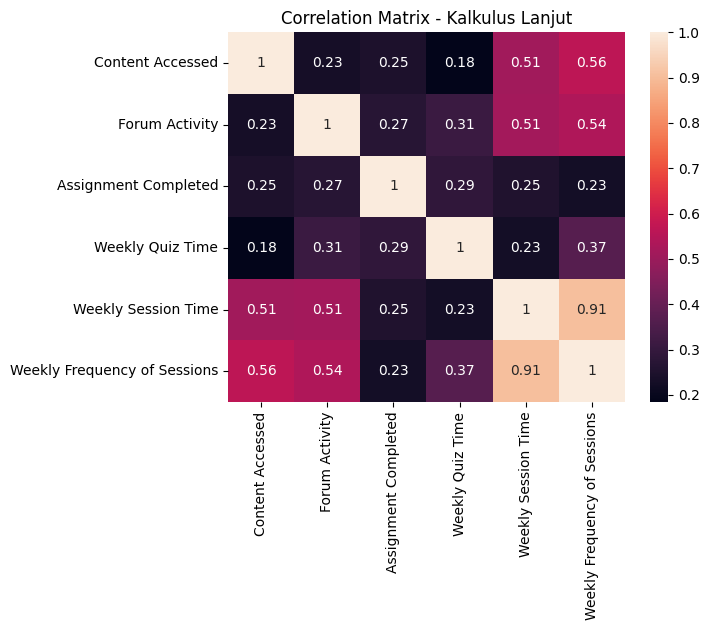

In [414]:
met = metrics.drop(columns=['User ID'])

sns.heatmap(met.corr(), annot=True)
plt.title('Correlation Matrix - Kalkulus Lanjut')
plt.show()

In [415]:
metrics

,User ID,Content Accessed,Forum Activity,Assignment Completed,Weekly Quiz Time,Weekly Session Time,Weekly Frequency of Sessions
0,1,2.0000,15.5000,5.2000,28.4270,38.3889,5.9444
1,2,0.6875,6.8571,0.0000,36.0000,13.8235,2.4706
2,3,2.8125,8.0000,3.0000,41.8042,38.1364,7.5000
3,4,2.5625,8.1333,2.8000,39.7135,38.6842,7.7368
4,5,1.3125,11.7143,5.0000,6.9986,32.8571,3.8571
5,6,0.0000,4.5000,5.0000,26.0000,38.3333,2.3333
6,7,1.2500,5.5714,0.0000,21.2000,27.4286,3.5714
7,8,0.3125,8.3333,3.0000,27.8214,22.4000,3.3333
8,9,5.5625,10.0000,4.5000,41.0938,27.9500,5.2000
9,10,0.0625,11.6000,3.0000,34.0104,8.1538,2.2308


In [416]:
X = metrics.drop(["User ID", "Weekly Frequency of Sessions"], axis=1).fillna(0)

X_scaled = StandardScaler().fit_transform(X)

### Y 3 Kluster

In [417]:
y_3_kluster = KMeans(n_clusters=3, random_state=42).fit_predict(X)

print(y_3_kluster)

# Mapping: class 1 -> class 0, class 2 -> class 1, class 0 -> class 2
new_labels = np.zeros_like(y_3_kluster)
new_labels[y_3_kluster == 1] = 0
new_labels[y_3_kluster == 2] = 1
new_labels[y_3_kluster == 0] = 2

print(new_labels)

[2 1 2 2 1 1 1 1 2 1 1 1 1 2 2 2 0 0 0 0 1 1 2 0 2 1 2 1 0 1 2 2 1 2 1 2 1
 2 1 1 1 1 1]
[1 0 1 1 0 0 0 0 1 0 0 0 0 1 1 1 2 2 2 2 0 0 1 2 1 0 1 0 2 0 1 1 0 1 0 1 0
 1 0 0 0 0 0]


## Pemodelan Machine Learning Decision Tree

In [418]:
metrics['cluster_3'] = new_labels

# Tambahkan kolom 'User full name' ke metrics dengan merge berdasarkan 'User ID'
# metrics = metrics.merge(df[['User ID', 'User full name']].drop_duplicates(), on='User ID', how='left')

metrics.drop(columns=['Weekly Frequency of Sessions'], inplace=True)

metrics

,User ID,Content Accessed,Forum Activity,Assignment Completed,Weekly Quiz Time,Weekly Session Time,cluster_3
0,1,2.0000,15.5000,5.2000,28.4270,38.3889,1
1,2,0.6875,6.8571,0.0000,36.0000,13.8235,0
2,3,2.8125,8.0000,3.0000,41.8042,38.1364,1
3,4,2.5625,8.1333,2.8000,39.7135,38.6842,1
4,5,1.3125,11.7143,5.0000,6.9986,32.8571,0
5,6,0.0000,4.5000,5.0000,26.0000,38.3333,0
6,7,1.2500,5.5714,0.0000,21.2000,27.4286,0
7,8,0.3125,8.3333,3.0000,27.8214,22.4000,0
8,9,5.5625,10.0000,4.5000,41.0938,27.9500,1
9,10,0.0625,11.6000,3.0000,34.0104,8.1538,0


### Visualisasi Data

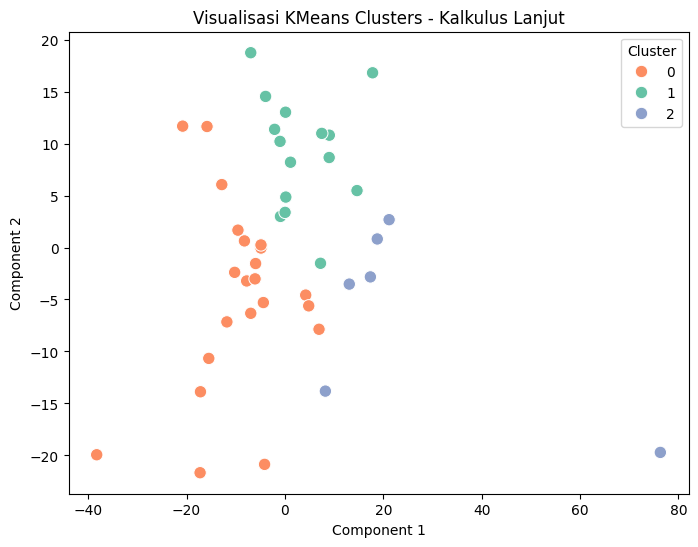

In [419]:
from sklearn.decomposition import PCA

# Pilih kolom X
X = metrics[['Content Accessed', 'Forum Activity', 'Assignment Completed',
        'Weekly Quiz Time', 'Weekly Session Time']]

# PCA ke 2 dimensi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Buat dataframe hasil PCA
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['Cluster'] = metrics['cluster_3'].astype(str)  # ubah jadi string untuk hue di plot

# Visualisasi
plt.figure(figsize=(8,6))
scatter = sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='Set2', s=80)

plt.title('Visualisasi KMeans Clusters - Kalkulus Lanjut')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

# Ambil handles & labels, lalu urutkan sesuai keinginan
handles, labels = scatter.get_legend_handles_labels()

# Buat mapping urutan baru
order = ['0', '1', '2']
# Filter dan urutkan
ordered = [(h, l) for h, l in zip(handles, labels) if l in order]
ordered.sort(key=lambda x: order.index(x[1]))

# Tampilkan legend dengan urutan baru
scatter.legend(handles=[h for h, l in ordered], labels=[l for h, l in ordered], title='Cluster')

plt.show()

In [420]:
metrics['Tingkat Motivasi'] = metrics['cluster_3'].replace({
    0: 'Rendah',
    1: 'Sedang',
    2: 'Tinggi'
})

['Sedang' 'Rendah' 'Tinggi']


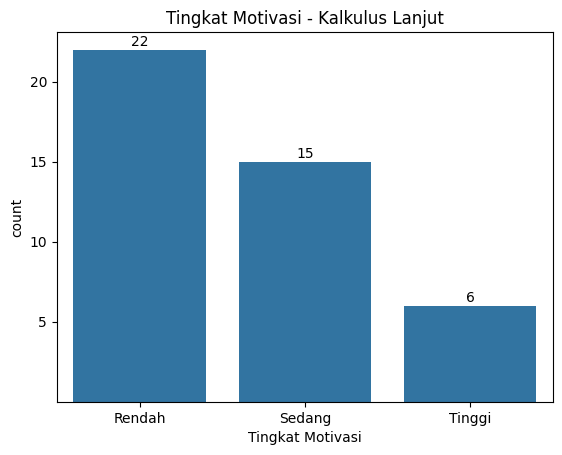

In [421]:
# Cek urutan unik kategorinya dulu
print(metrics['Tingkat Motivasi'].unique())
order = ['Rendah', 'Sedang', 'Tinggi']

# Plotting countplot dengan urutan baru
ax = sns.countplot(x='Tingkat Motivasi', data=metrics, order=order)
plt.title('Tingkat Motivasi - Kalkulus Lanjut')

# Menambahkan angka di atas setiap bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 0.05,
            f'{height:.0f}', ha='center', va='bottom')

# Menampilkan angka 5, 10, 15, 20 di sumbu y
plt.yticks([5, 10, 15, 20])

plt.show()

### Base Model

Train-test split data, 80% train - 20% test

In [422]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [423]:
X = metrics.drop(columns=['cluster_3', 'Tingkat Motivasi'])
y = metrics['cluster_3']

X_train, X_test, y_train, y_test = train_test_split(
    X,            # Features
    y,            # Target variable
    test_size=0.2, 
    random_state=6, 
    stratify=y_3_kluster
)

Cross-validation scores: [1.         0.57142857 0.71428571 0.85714286 0.5       ]
Average CV score: 0.7285714285714285


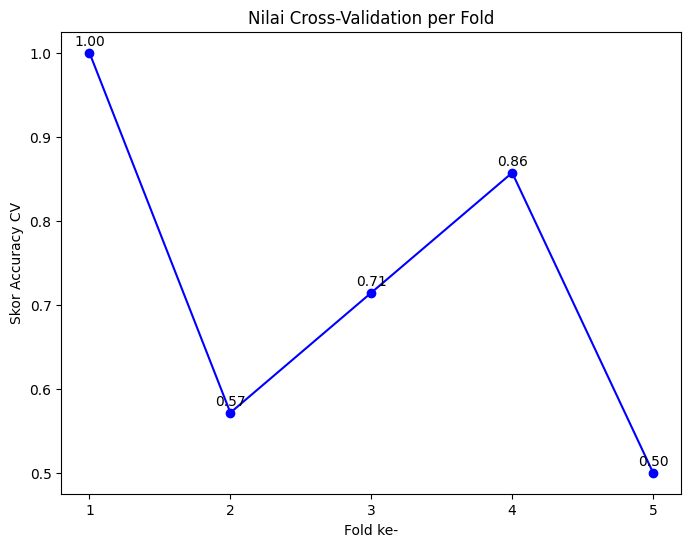

In [424]:
dt = DecisionTreeClassifier(random_state=6)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=6)

# Menghitung cross-validation score dengan stratified k-fold
cv_scores = cross_val_score(dt, X_train, y_train, cv=skf)

# Menampilkan hasil cross-validation
print(f'Cross-validation scores: {cv_scores}')
print(f'Average CV score: {cv_scores.mean()}')

# Plot nilai CV dengan line plot
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(cv_scores) + 1), cv_scores, marker='o', linestyle='-', color='b')

# Menambahkan anotasi untuk setiap fold
for i, score in enumerate(cv_scores, 1):
    plt.text(i, score + 0.005, f'{score:.2f}', ha='center', va='bottom', fontsize=10)

plt.title('Nilai Cross-Validation per Fold')
plt.xlabel('Fold ke-')
plt.ylabel('Skor Accuracy CV')
plt.xticks(np.arange(1, len(cv_scores) + 1))
plt.show()

In [425]:
# Melatih model pada data training
dt.fit(X_train, y_train)

# Memprediksi menggunakan data pengujian
y_pred = dt.predict(X_test)

# Menghitung akurasi pada data testing
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on test data: {accuracy}')

from sklearn.metrics import classification_report

y_pred = dt.predict(X_test)
print(classification_report(y_test, y_pred, digits=4)) 

Accuracy on test data: 1.0
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         5
           1     1.0000    1.0000    1.0000         3
           2     1.0000    1.0000    1.0000         1

    accuracy                         1.0000         9
   macro avg     1.0000    1.0000    1.0000         9
weighted avg     1.0000    1.0000    1.0000         9



### Hyperparameter Tuning

In [426]:
from sklearn.model_selection import GridSearchCV

# Inisialisasi model dasar
dt_tune = DecisionTreeClassifier(random_state=6)

# Buat grid hyperparameter
param_grid = {
    'max_depth': [None, 3, 5, 7, 10, 15],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Inisialisasi StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=6)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=dt_tune,
    param_grid=param_grid,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1
)

# Jalankan grid search
grid_search.fit(X_train, y_train)

# Hasil terbaik
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluasi ulang dengan model terbaik
best_dt = grid_search.best_estimator_

# Prediksi di test data
y_pred = best_dt.predict(X_test)

# Hitung akurasi
from sklearn.metrics import accuracy_score, classification_report

accuracy_after = accuracy_score(y_test, y_pred)
print(f'Accuracy on test data: {accuracy_after}')
print(classification_report(y_test, y_pred, digits=4))


Best parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation score: 0.8428571428571429
Accuracy on test data: 1.0
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         5
           1     1.0000    1.0000    1.0000         3
           2     1.0000    1.0000    1.0000         1

    accuracy                         1.0000         9
   macro avg     1.0000    1.0000    1.0000         9
weighted avg     1.0000    1.0000    1.0000         9



Cross-validation scores: [1.         1.         0.85714286 0.85714286 0.5       ]
Average CV score: 0.8428571428571429


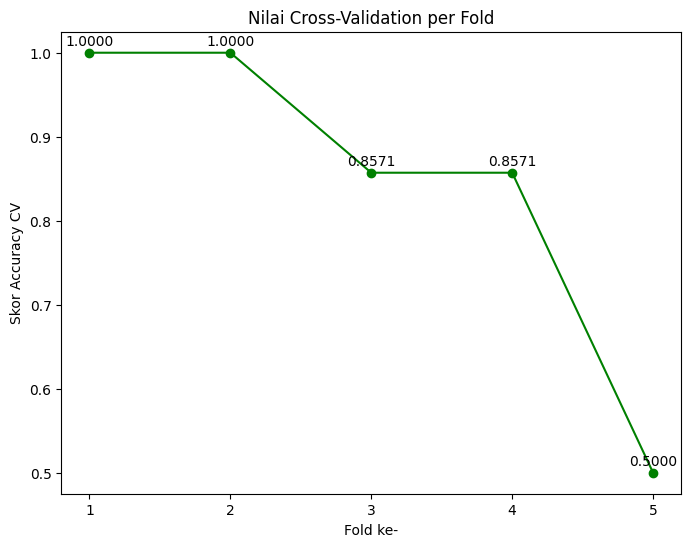

In [427]:
# Menghitung cross-validation score dengan stratified k-fold
cv_scores_after = cross_val_score(best_dt, X_train, y_train, cv=skf)

# Menampilkan hasil cross-validation
print(f'Cross-validation scores: {cv_scores_after}')
print(f'Average CV score: {cv_scores_after.mean()}')

# Plot nilai CV dengan line plot
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(cv_scores_after) + 1), cv_scores_after, marker='o', linestyle='-', color='g')

# Menambahkan anotasi untuk setiap fold
for i, score in enumerate(cv_scores_after, 1):
    plt.text(i, score + 0.005, f'{score:.4f}', ha='center', va='bottom', fontsize=10)

plt.title('Nilai Cross-Validation per Fold')
plt.xlabel('Fold ke-')
plt.ylabel('Skor Accuracy CV')
plt.xticks(np.arange(1, len(cv_scores_after) + 1))
plt.show()

In [428]:
print("Detail Hasil dari Setiap Kombinasi Hyperparameter:")
results_df = pd.DataFrame(grid_search.cv_results_)

relevant_columns = ["params", "mean_test_score", "std_test_score", "rank_test_score"]
results_df = results_df[relevant_columns].sort_values(by="rank_test_score")
print(results_df.to_string())

Detail Hasil dari Setiap Kombinasi Hyperparameter:
                                                                                           params  mean_test_score  std_test_score  rank_test_score
116       {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}         0.842857        0.182946                1
114      {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10}         0.842857        0.182946                1
117       {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5}         0.842857        0.182946                1
118      {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10}         0.842857        0.182946                1
96     {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}         0.842857        0.182946                1
97     {'criterion': 'entropy', 'max_depth': None, 'min_sampl

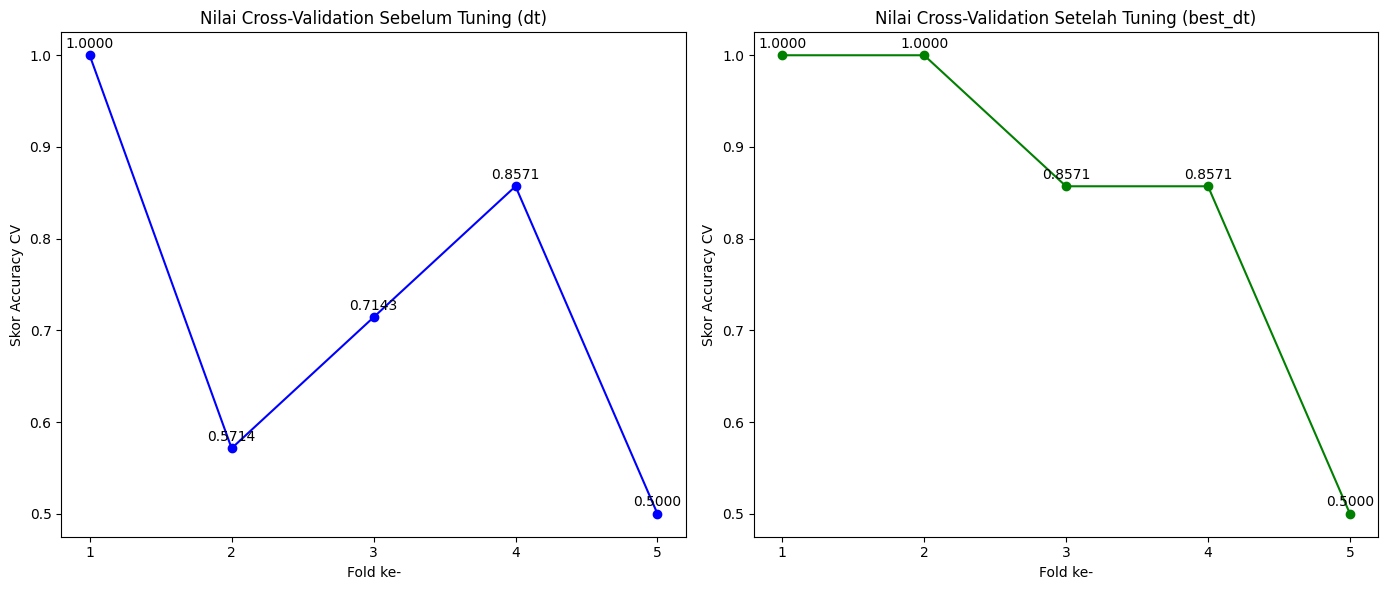

In [429]:
# StratifiedKFold untuk cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=6)

# Menghitung cross-validation score dengan dt (sebelum tuning)
cv_scores_before = cross_val_score(dt, X_train, y_train, cv=skf)

# Menghitung cross-validation score dengan best_dt (setelah tuning)
cv_scores_after = cross_val_score(best_dt, X_train, y_train, cv=skf)

# Membuat side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot untuk sebelum tuning
axes[0].plot(np.arange(1, len(cv_scores_before) + 1), cv_scores_before, marker='o', linestyle='-', color='b')
for i, score in enumerate(cv_scores_before, 1):
    axes[0].text(i, score + 0.005, f'{score:.4f}', ha='center', va='bottom', fontsize=10)
axes[0].set_title('Nilai Cross-Validation Sebelum Tuning (dt)')
axes[0].set_xlabel('Fold ke-')
axes[0].set_ylabel('Skor Accuracy CV')
axes[0].set_xticks(np.arange(1, len(cv_scores_before) + 1))

# Plot untuk setelah tuning
axes[1].plot(np.arange(1, len(cv_scores_after) + 1), cv_scores_after, marker='o', linestyle='-', color='g')
for i, score in enumerate(cv_scores_after, 1):
    axes[1].text(i, score + 0.005, f'{score:.4f}', ha='center', va='bottom', fontsize=10)
axes[1].set_title('Nilai Cross-Validation Setelah Tuning (best_dt)')
axes[1].set_xlabel('Fold ke-')
axes[1].set_ylabel('Skor Accuracy CV')
axes[1].set_xticks(np.arange(1, len(cv_scores_after) + 1))

# Menampilkan kedua plot
plt.tight_layout()
plt.show()

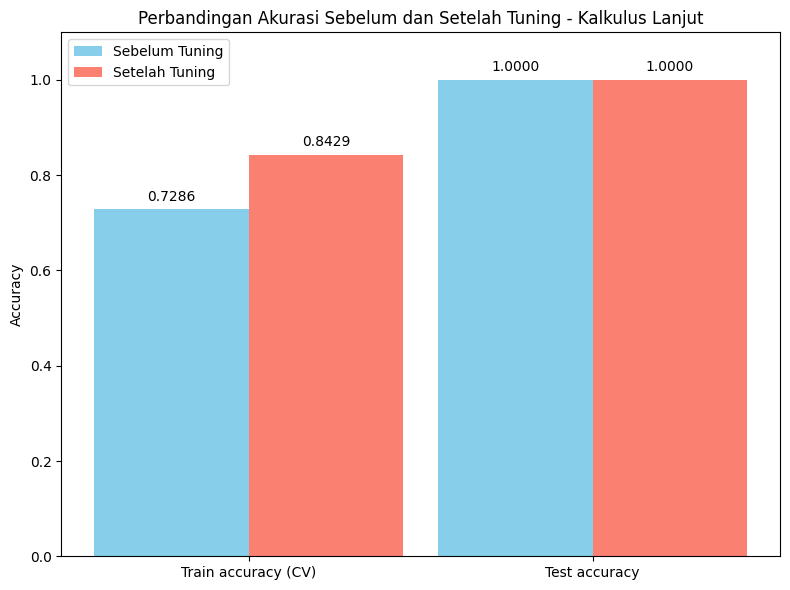

In [430]:
# Visualisasi
labels = ['Train accuracy (CV)', 'Test accuracy']
before = [np.mean(cv_scores), accuracy]
after = [grid_search.best_score_, accuracy_after]

x = np.arange(len(labels))
width = 0.45

fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(x - width/2, before, width, label='Sebelum Tuning', color='skyblue')
rects2 = ax.bar(x + width/2, after, width, label='Setelah Tuning', color='salmon')

ax.set_ylabel('Accuracy')

# Naikkan batas atas sumbu y agar label tidak ketimpa
max_height = max(max(before), max(after))
ax.set_ylim(0, max_height + 0.1)

ax.set_title('Perbandingan Akurasi Sebelum dan Setelah Tuning - Kalkulus Lanjut')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Tampilkan nilai di atas bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',  # tampilkan 4 angka di belakang koma
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 4), textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


### SHAP Values

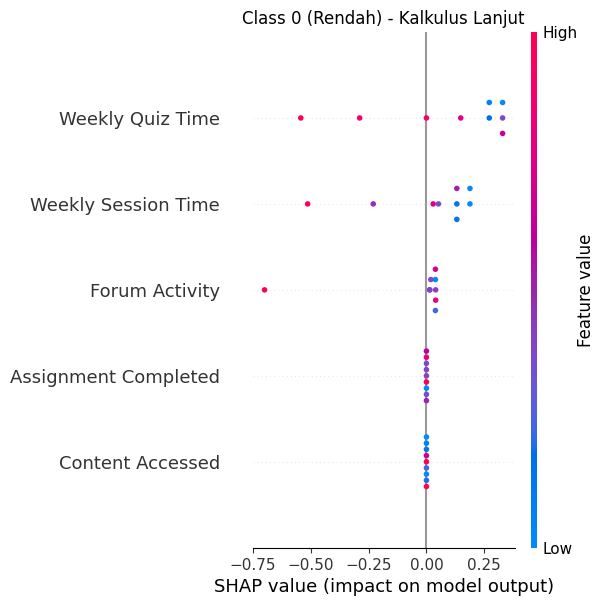

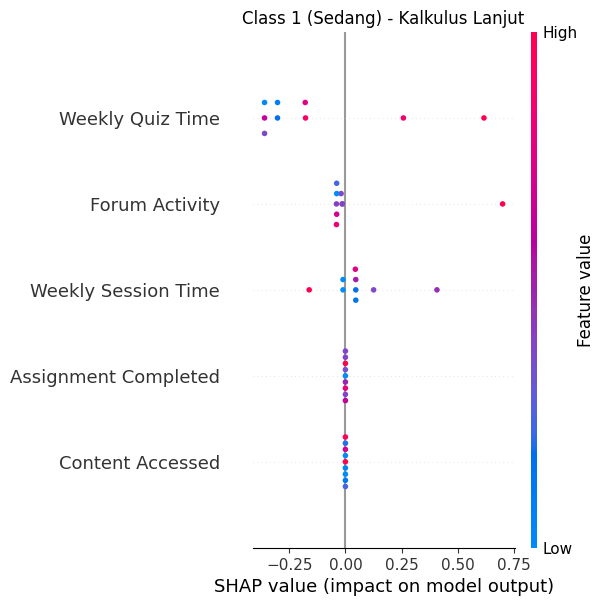

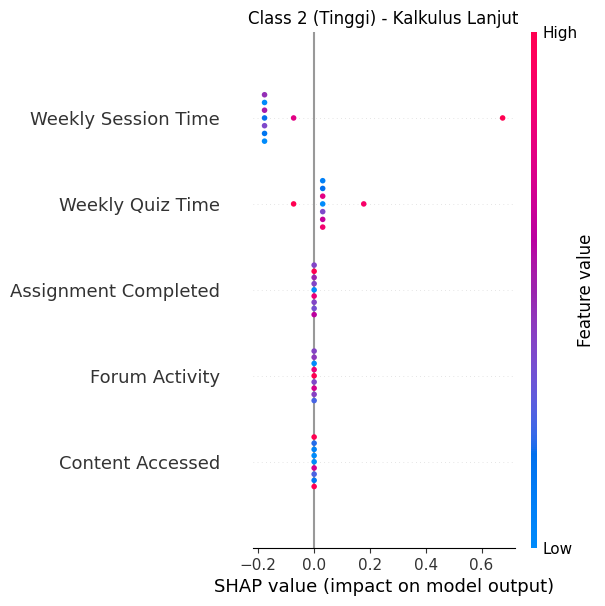

In [431]:
import shap
import matplotlib.pyplot as plt

# Compute SHAP values for the trained decision tree
explainer = shap.TreeExplainer(dt)
shap_values = explainer.shap_values(X_test)

selected_features = ["Content Accessed", "Forum Activity", "Assignment Completed", 
                     "Weekly Quiz Time", "Weekly Session Time"]

X_test_selected = X_test[selected_features]

# Dapatkan indeks fitur terpilih sesuai urutan di X_test.columns
selected_idx = [X_test.columns.get_loc(f) for f in selected_features]

# Subset shap_values untuk fitur tersebut
shap_values_selected_0 = shap_values[:, selected_idx, 0]
shap_values_selected_1 = shap_values[:, selected_idx, 1]
shap_values_selected_2 = shap_values[:, selected_idx, 2]

# Plot - tambah plot_size
shap.summary_plot(shap_values_selected_0, X_test_selected, show=False, plot_size=(6,6))
plt.title("Class 0 (Rendah) - Kalkulus Lanjut")
plt.show()

shap.summary_plot(shap_values_selected_1, X_test_selected, show=False, plot_size=(6,6))
plt.title("Class 1 (Sedang) - Kalkulus Lanjut")
plt.show()

shap.summary_plot(shap_values_selected_2, X_test_selected, show=False, plot_size=(6,6))
plt.title("Class 2 (Tinggi) - Kalkulus Lanjut")
plt.show()

### Confussion Matrix

[[5 0 0]
 [0 3 0]
 [0 0 1]]


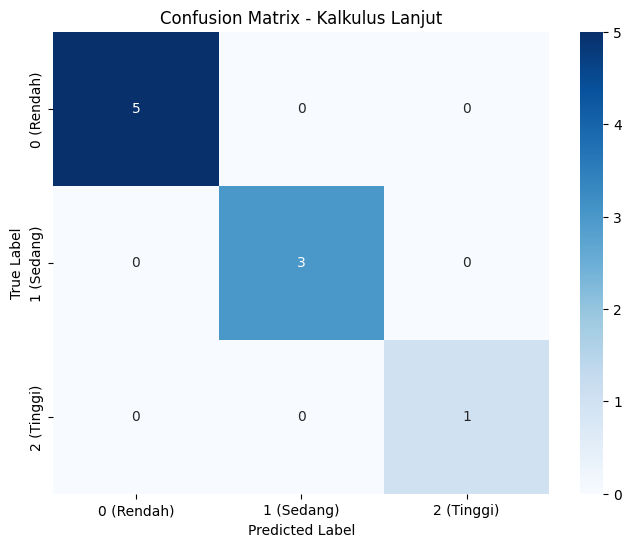

In [432]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_test, best_dt.predict(X_test))
print(cm)

# Create the plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0 (Rendah)', '1 (Sedang)', '2 (Tinggi)'], 
            yticklabels=['0 (Rendah)', '1 (Sedang)', '2 (Tinggi)'])
plt.title('Confusion Matrix - Kalkulus Lanjut')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()